<a href="https://colab.research.google.com/github/naenumtou/creditrisk/blob/main/modifySampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/BScore

/content/drive/My Drive/Colab Notebooks/BScore


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

In [ ]:
# Import data
transaction = pd.read_parquet(
    'devTransaction.parquet',
    engine = 'pyarrow'
)
print(f'Total rows: {transaction.shape[0]}')
print(f'Total columns: {transaction.shape[1]}')

Total rows: 356335
Total columns: 286


In [ ]:
# Normal train/test split
train, test = train_test_split(
    transaction,
    test_size = 0.3,
    stratify = transaction['everDefault12'],
    random_state = 101
)
print(f'Training size: {train.shape[0]}')
print(f'Testing size: {test.shape[0]}')

Training size: 249434
Testing size: 106901


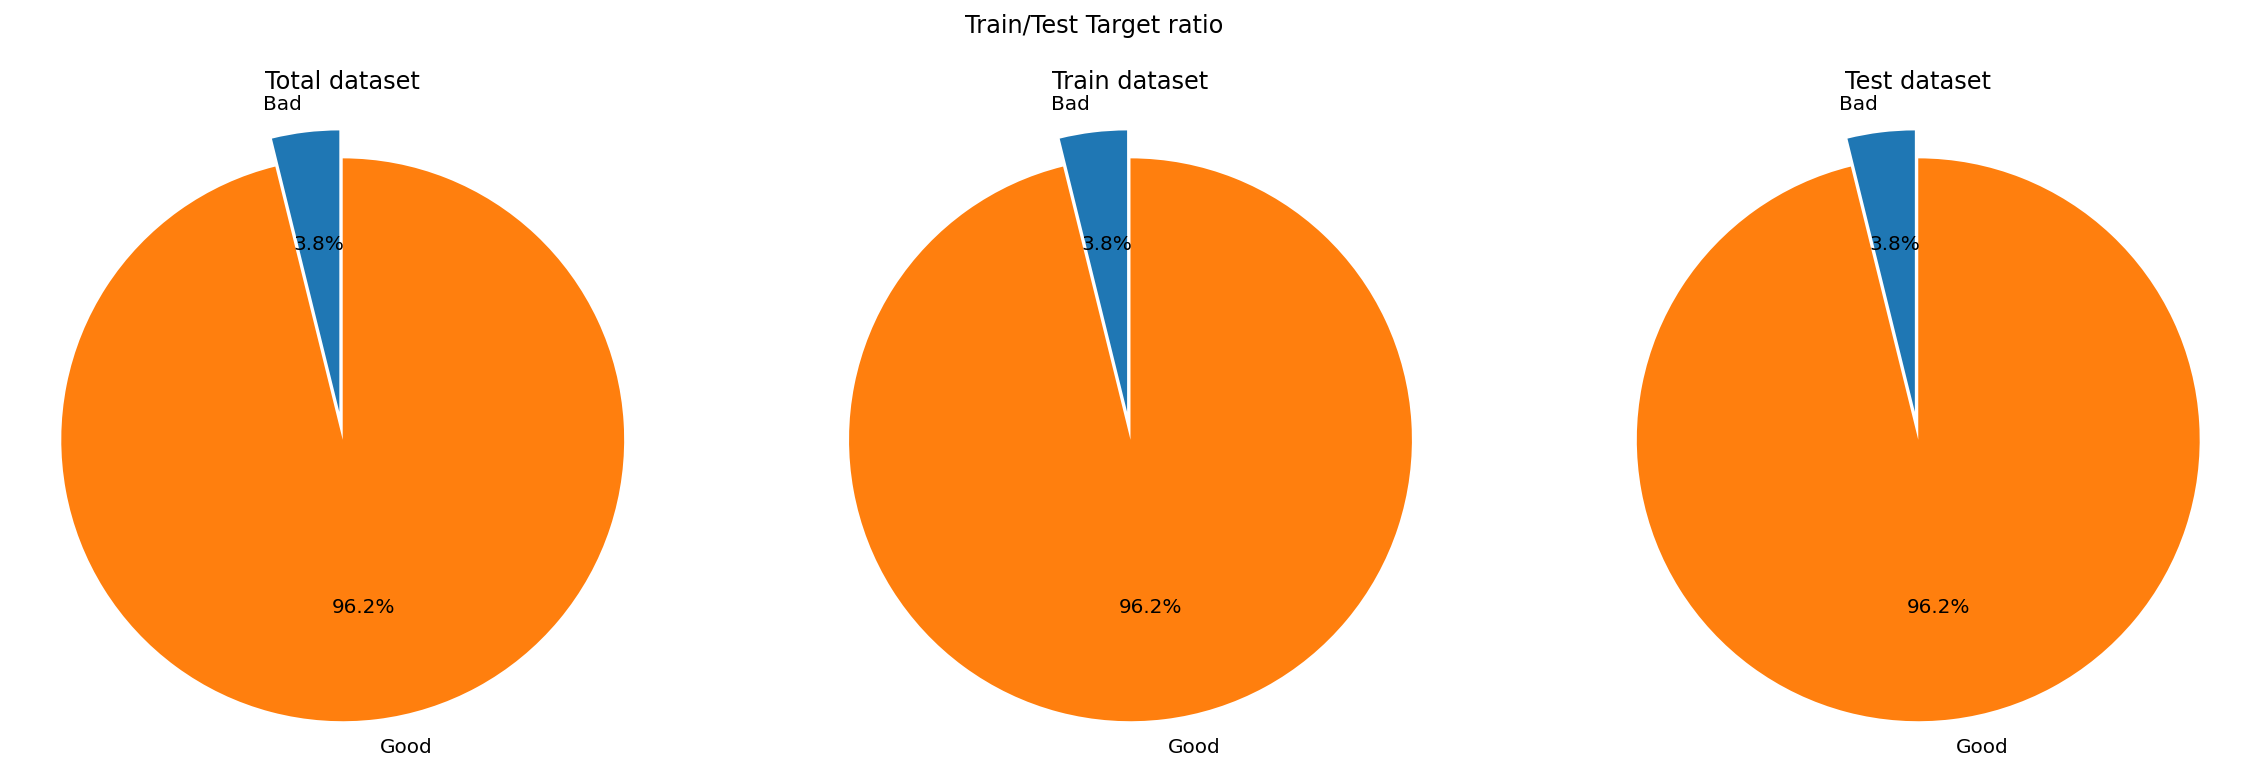

In [ ]:
# Define plot sample function
def plotSample(allset, trainset, testset):
  data = pd.concat(
      [
       allset['everDefault12'].rename('Total'),
       trainset['everDefault12'].rename('Train'),
       testset['everDefault12'].rename('Test')
      ],
      axis = 1
  )
  fig, axs = plt.subplots(1, 3, figsize = (20, 6))
  axs = axs.ravel()
  fig.suptitle('Train/Test Target ratio')
  for i, col in enumerate(data.columns):
    sizes = [
             data[col].sum(),
             data[col].count() - data[col].sum()
    ]
    axs[i].pie(
        sizes,
        explode = (0.1, 0),
        labels = ['Bad', 'Good'],
        autopct = '%1.1f%%',
        startangle = 90
    )
    axs[i].axis('equal')
    axs[i].set_title(f'{col} dataset')
  return plt.show()

# Plot
plotSample(transaction, train, test)

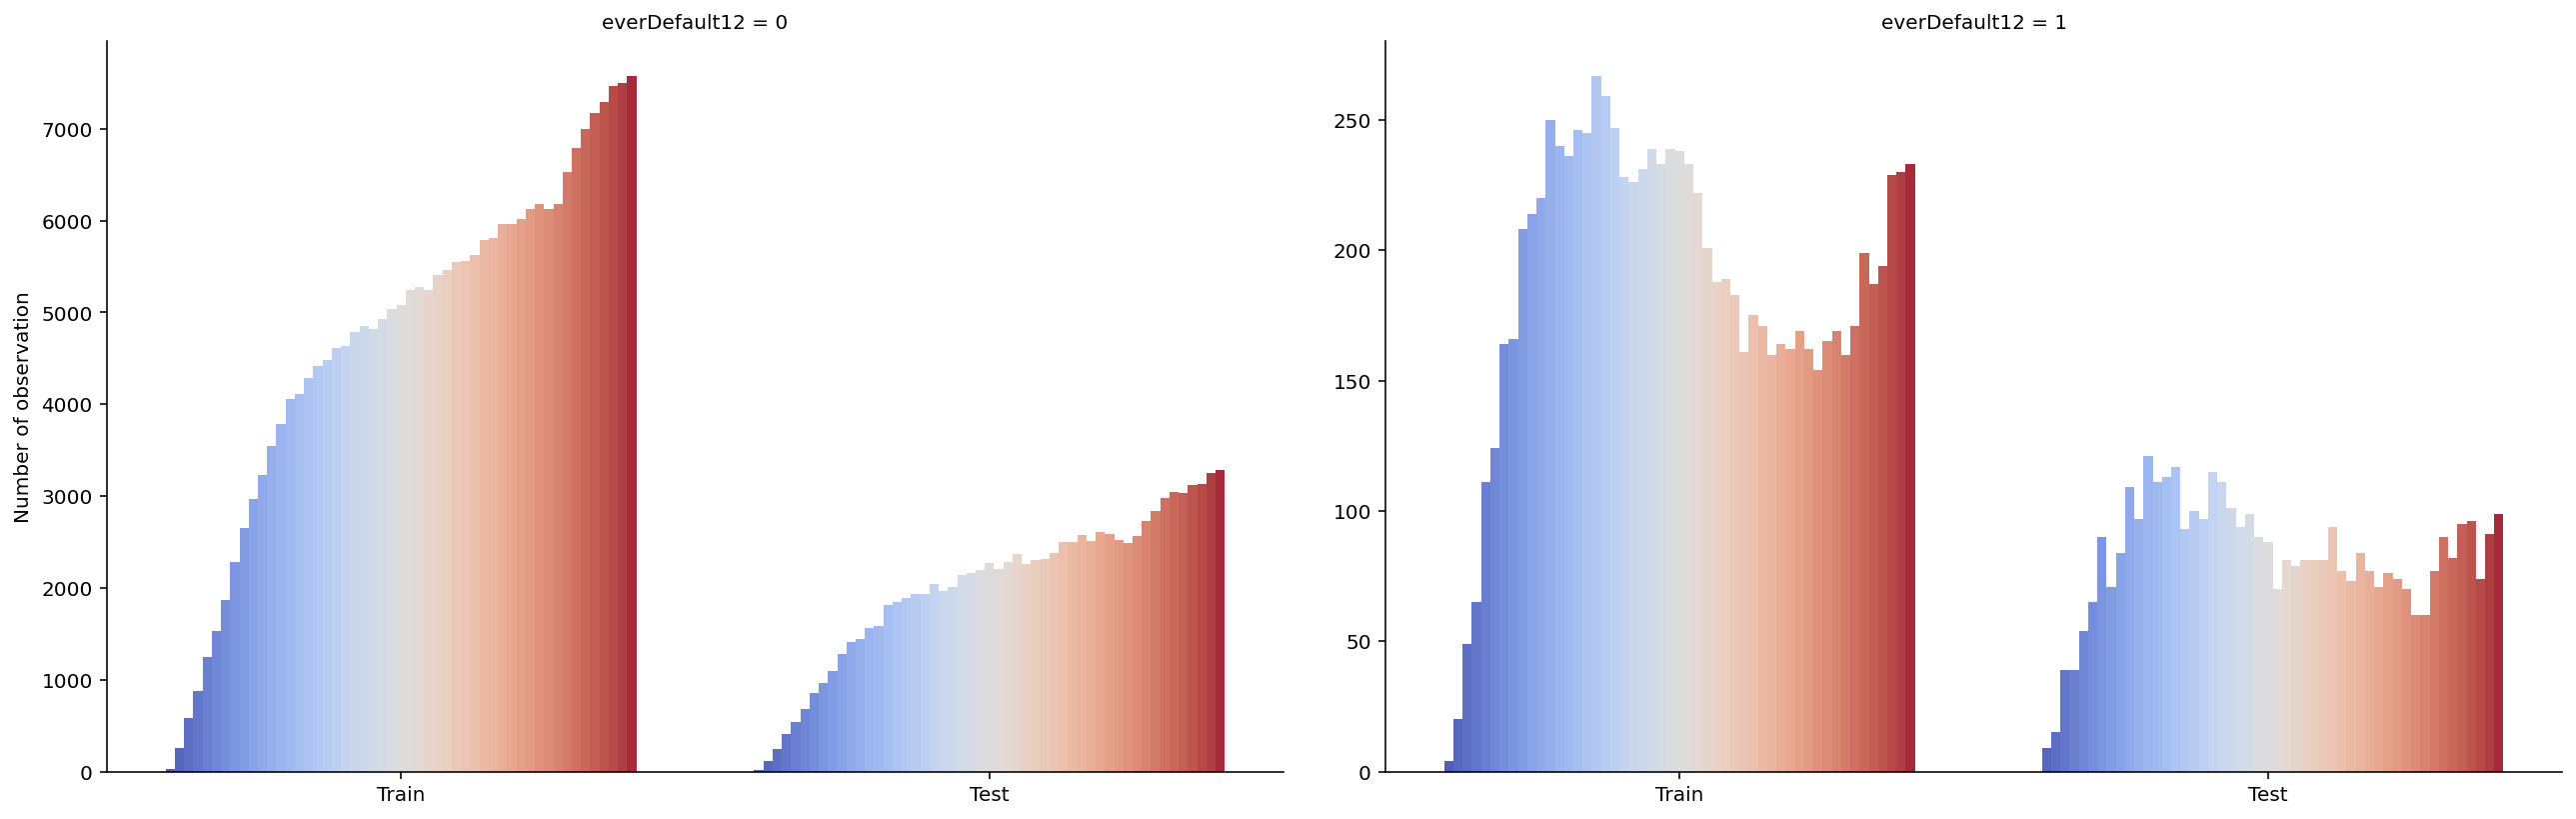

In [ ]:
# Define plot distribution function
def plotDist(trainset, testset):
  dataTrain, dataTest = trainset[['Monthkey', 'everDefault12']].copy(deep = True), testset[['Monthkey', 'everDefault12']].copy(deep = True)
  dataTrain['Sample'], dataTest['Sample'] = 'Train', 'Test'
  dataAll = pd.concat(
      [dataTrain, dataTest],
      axis = 0
  )
  with plt.style.context('seaborn-deep'):
    ax = sns.catplot(
      x = 'Sample',
      hue = 'Monthkey',
      col = 'everDefault12',
      data = dataAll,
      kind = 'count',
      palette = 'coolwarm',
      legend = False,
      sharey = False,
      height = 6,
      aspect = 1.5
    )
    ax.set_axis_labels('', 'Number of observation')
  return plt.show()

# Plot
plotDist(train, test)

In [ ]:
# Issue
# The customer is avaliable in both datasets
# Find the customer number
sampleCus = train[
                   train['Br_Con'].isin(
                       test['Br_Con']
                   )
]['Br_Con'].sample(1).values[0]

# Show table
train[train['Br_Con'] == sampleCus].head(5)

In [ ]:
# Show table
test[test['Br_Con'] == sampleCus].head(5)

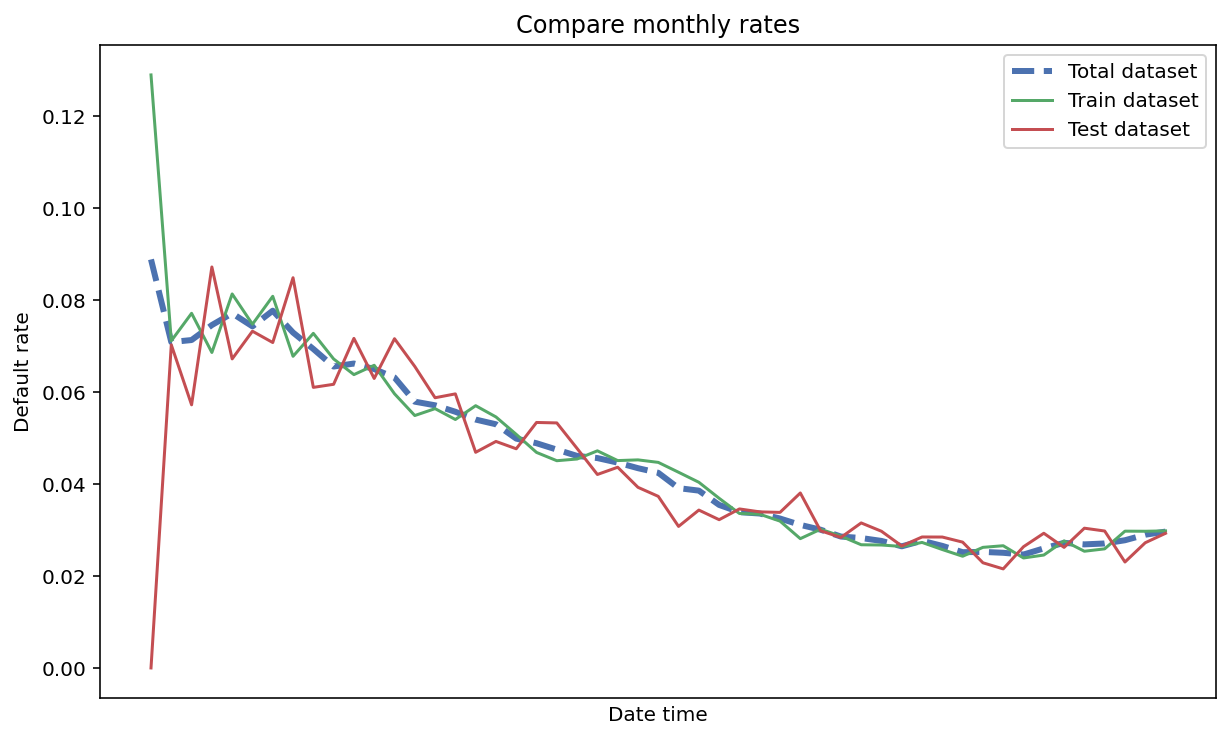

In [ ]:
# Define plot rate function
def plotRate(allset, trainset, testset):
  plt.figure(figsize = (10, 6))
  with plt.style.context('seaborn-deep'):
    plt.plot(
        allset.groupby(['Monthkey'])['everDefault12'].sum() / allset.groupby(['Monthkey'])['everDefault12'].count(),
        linewidth = 3,
        linestyle = '--',
        label = 'Total dataset'
    )
    plt.plot(
        trainset.groupby(['Monthkey'])['everDefault12'].sum() / trainset.groupby(['Monthkey'])['everDefault12'].count(),
        label = 'Train dataset'
    )
    plt.plot(
        testset.groupby(['Monthkey'])['everDefault12'].sum() / testset.groupby(['Monthkey'])['everDefault12'].count(),
        label = 'Test dataset'
    )
    plt.title('Compare monthly rates')
    plt.xticks([])
    plt.xlabel('Date time')
    plt.ylabel('Default rate')
    plt.legend(frameon = True, facecolor = 'white')
  return plt.show()

# Plot
plotRate(transaction, train, test)

In [ ]:
# Define sampling function
def TrainTestSplie(data, key, y, tests_size, threshold1, threshold2):
  # Parameters
  conUnique = np.unique(data[key]) #Create unique list of contract number
  totalODR = data[y].sum() / data[y].count()
  monthlyODR = data.groupby(['Monthkey'])[y].sum() / data.groupby(['Monthkey'])[y].count() 
  # Threshold
  totalThres = threshold1 #Overall ODR threshold
  monthlyThres = threshold2 #Monthly ODR threshold
  reSampling = True
  while reSampling:
    reSampling = False
    conTrain, conTest = train_test_split(conUnique, test_size = tests_size)
    # Create sampling dataset
    train = data[data[key].isin(conTrain)]
    test = data[data[key].isin(conTest)]
    # Create ODR
    trainODR = train[y].sum() / train[y].count()
    testODR = test[y].sum() / test[y].count()
    trainMonthly = train.groupby(['Monthkey'])[y].sum() / train.groupby(['Monthkey'])[y].count() 
    testMonthly = test.groupby(['Monthkey'])[y].sum() / test.groupby(['Monthkey'])[y].count()
    # Compare ODR
    diff1 = abs(totalODR - trainMonthly) > monthlyThres
    diff2 = abs(totalODR - testMonthly) > monthlyThres
    diff3 = abs(trainMonthly - testMonthly) > monthlyThres
    if (abs(totalODR - trainODR) > totalThres or
        abs(totalODR - testODR) > totalThres or
        abs(trainODR - testODR) > totalThres or
        diff1.any() or
        diff2.any() or
        diff3.any()
    ):
      print('Processing...')
      reSampling = True
    else:
      print('Done')
  return train, test

In [ ]:
# Conditional train/test split
trainNew, testNew = TrainTestSplie(
    data = transaction,
    key = 'Br_Con',
    y = 'everDefault12',
    tests_size = 0.3,
    threshold1 = 0.005,
    threshold2 = 0.06
)

Done


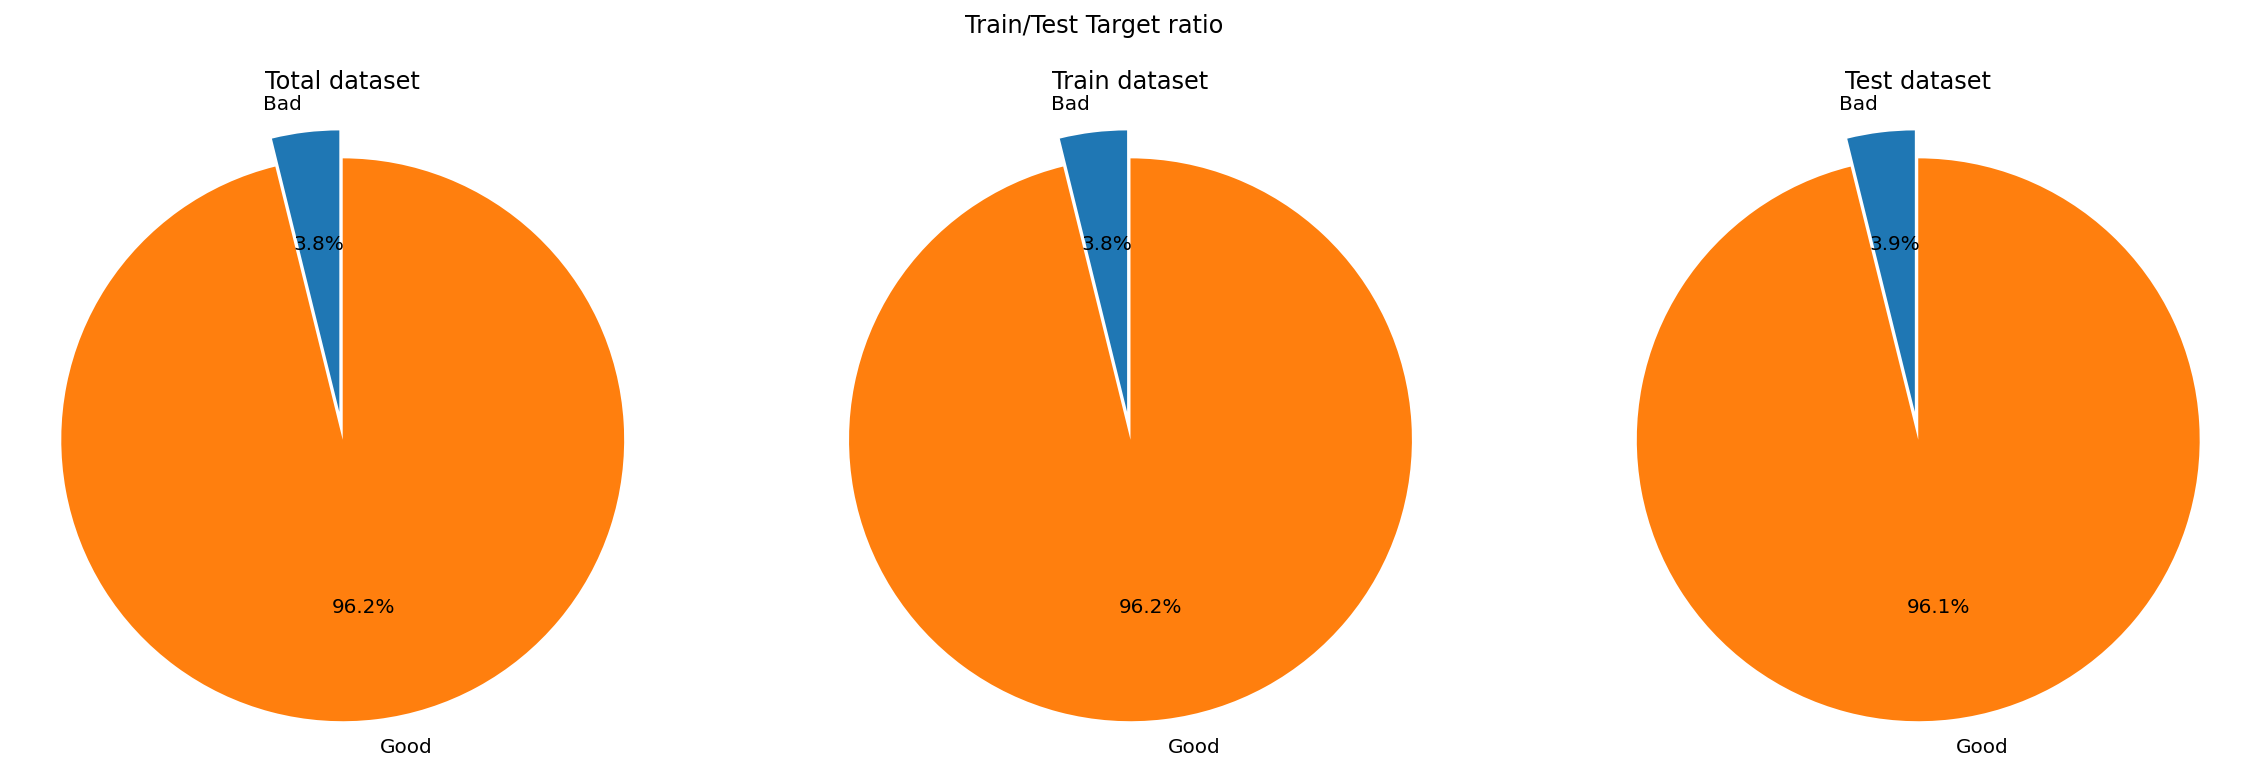

In [ ]:
# Plot sample
plotSample(transaction, trainNew, testNew)

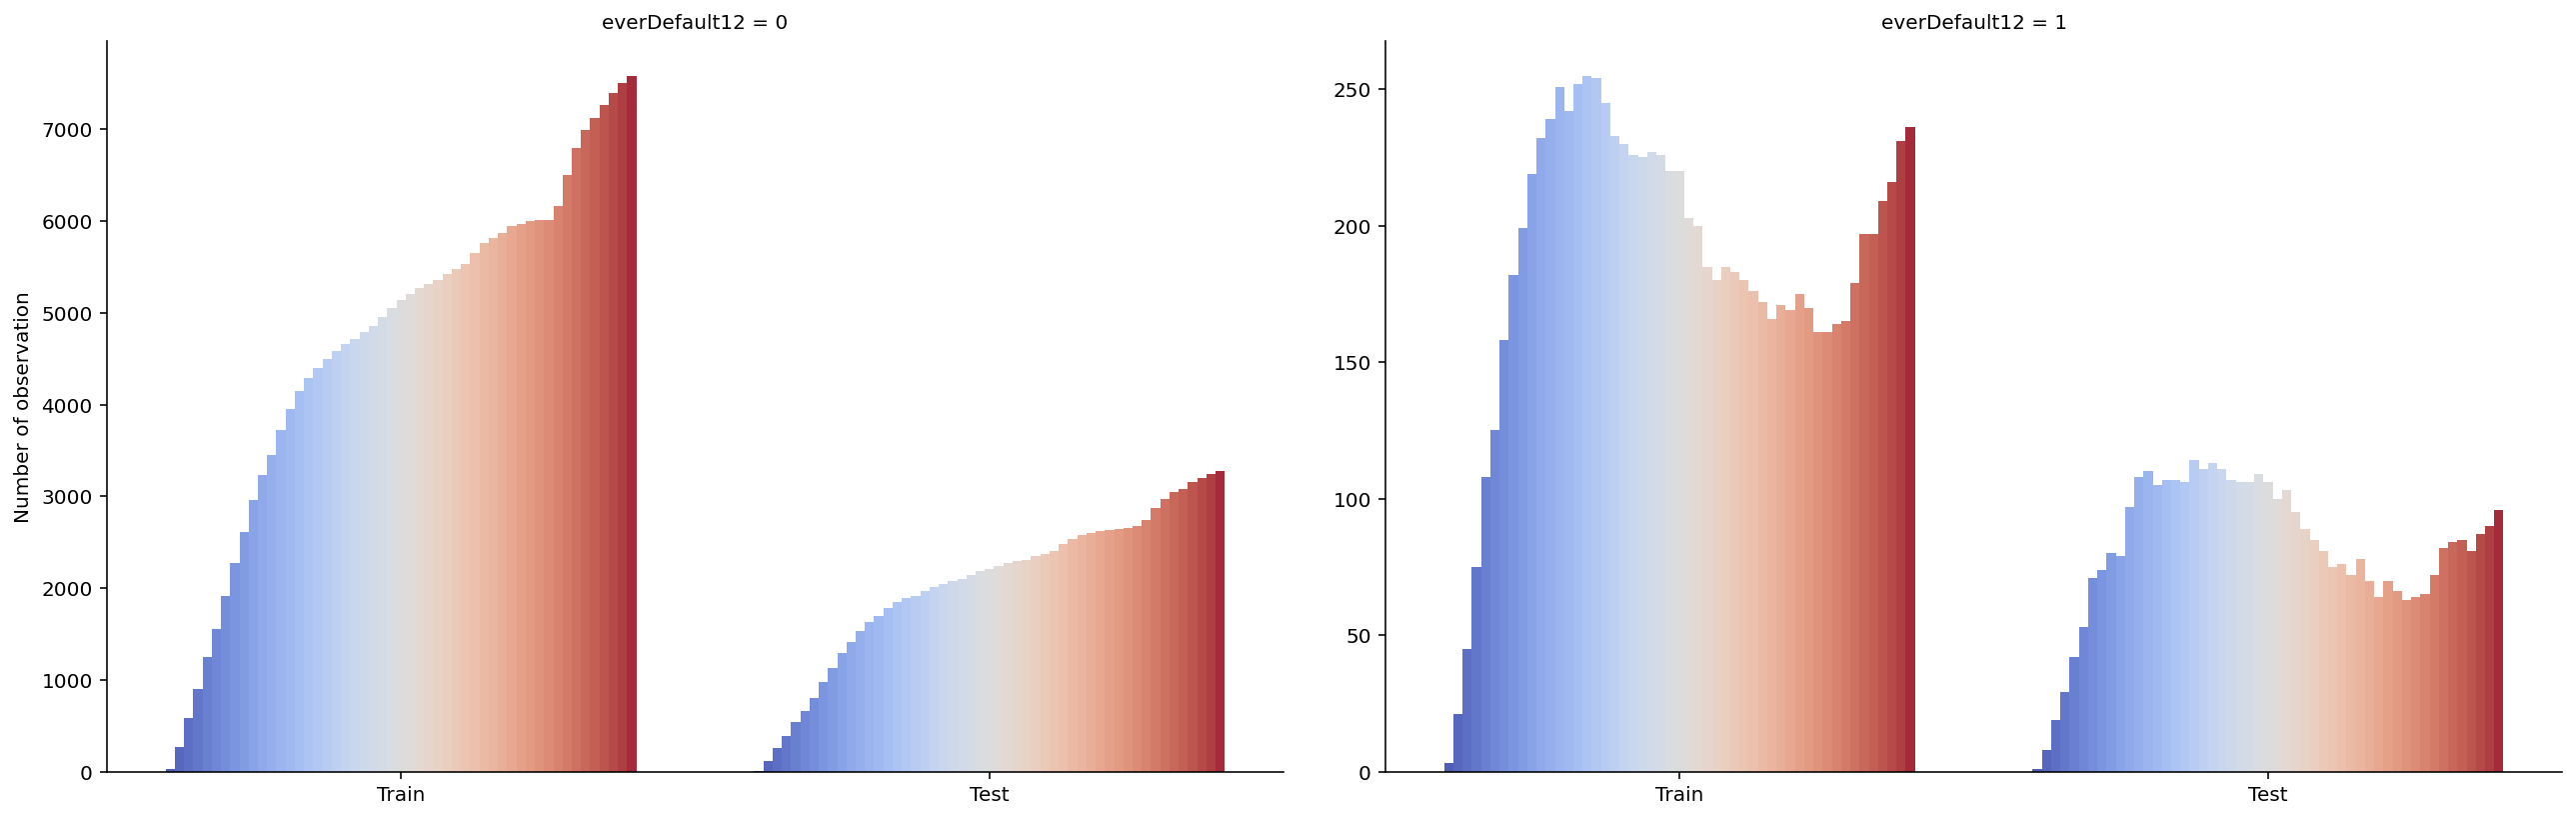

In [ ]:
# Plot distribution
plotDist(trainNew, testNew)

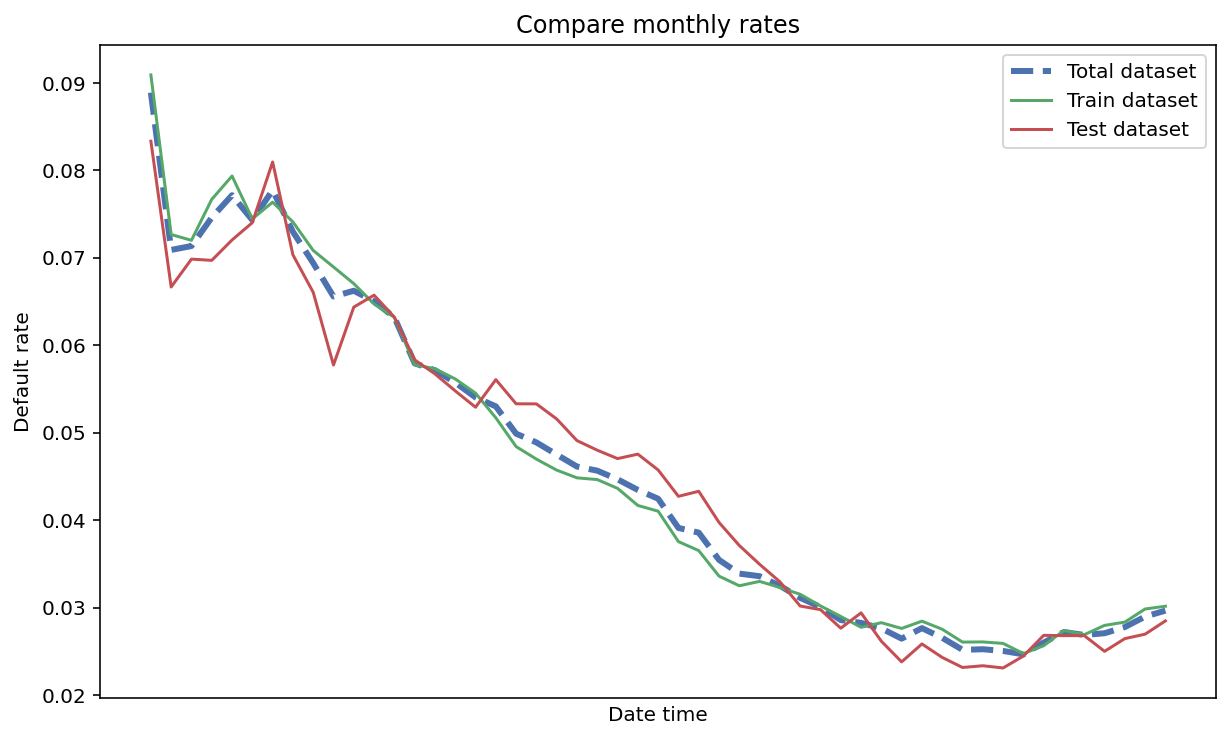

In [ ]:
# Plot rate
plotRate(transaction, trainNew, testNew)

In [ ]:
# Export
trainNew.to_parquet(
    'trainTransaction.parquet',
    engine = 'pyarrow'
)
testNew.to_parquet(
    'testTransaction.parquet',
    engine = 'pyarrow'
)